<i> War is the continuation of politics by other means. </i>
    
    Karl von Clausewitz

Before delving into CoW, we will create a Markov model that captures many of the major dynamics in an interstate alliance system.

In a Markov model, current system state is determined only by previous state combined with a set of transition probabilities and update rules. In an NxN country system, we care about the following elements of state:

- War: Whether two countries are at war.
- Affinity: The military dynamic between two countries, including aid and alliance.
- Power: Relative power dynamics of each country pair.
- Events: Exogenous events provoking conflict.

We will discretize as follows:

- War: {0, 1}; 0 is war and 1 is peace.
- Affinity: {-1, -.5, 0, .5, 1}; 1 represents full opposition, 0.5 negative indirect activity (arms shipments, political pressure, or other opposition), 0 no interaction, -0.5 positive indirect activity, and -1 full alliance.
- Power: {-1, -.9, ..., 1}; -1 is minimum relative power (capitulation) and 1 is maximum power.
- Events: {-1, -.9, ..., 1}; -1 is a maximally tension-lowering event, 0 is no event, and 1 is a maximally tension-raising event.

We also may want to capture elements of geographical location and policy through the following fixed variables:

- Proximity: {0, .25, .5, .75, 1}; 0 for no potential interaction fronts and 1 for neighboring countries.
- Aggression: {-1, -.5, 0, .5, 1}; -1 for peaceful orientation and 1 for aggressive orientation.

Whether two countries are at war will depend on the following elements of the prior state:

- Prior war status of self and allies
- Current affinity
- Event influence
- Base transition probabilities and aggression levels

Affinity is affected by the following:

- Prior war status
- Prior affinity
- Prior relative power
- Base transition probabilities

Power is affected by the following:

- Prior power
- Prior power- and proximity-adjusted influence of allies and enemies

We will begin by modeling with a "season" (3-month interval) as the timestep.

Therefore, this should be our final model:

    war(c1, c2, t): f(
        war(c1, c2, t-1),
        [war(c2, c3, t-1) * affinity(c1, c3, t) for c3 != c1,c2],
        [war(c1, c3, t-1) * affinity(c2, c3, t) for c3 != c1,c2],
        affinity(c1, c2, t-1),
        event(c1, c2, t-1),
        power(c1, t-1),
        power(c2, t-1),
        aggression(c1),
        aggression(c2)
    )
        
    affinity(c1, c2, t): f(
        war(c1, c2, t-1),
        affinity(c1, c2, t-1),
        power(c1, t-1),
        power(c2, t-1)
    )
    
    power(c1, t): f(
        power(c1, t-1),
        [affinity(c1, c2, t-1) * power(c2, t-1) * proximity(c1, c2) for c2 != c1]
    )

Our plan of attack:

0. Encode simple update rules and state machine
1. Set base parameters and transition probabilities
2. Simulate and evaluate results for WWI 
3. Encode full update rules
4. Estimate true parameters and probabilities from CoW
5. Simulate and evaluate results for WWI
6. Experiment with other international systems

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import seaborn as sns

First, some initial conditions:

In [2]:
# Order: Austria (Austria-Hungary), England (Britain), France, Germany, Italy, Russia, Turkey (Ottoman Empire)

def countries():
    return ['A', 'E', 'F', 'G', 'I', 'R', 'T']

def countries_full():
    return ['Austria-Hungary', 'England', 'France', 'Germany', 'Italy', 'Russia', 'Ottoman Empire']

def index():
    return {c: i for i, c in enumerate(countries)}

N = len(countries())

def war_init():
    return np.zeros((N, N))

def affinity_init():
    return np.zeros((N, N))

def power_init():
    return np.zeros((N))

def aggression():
    return np.zeros((N))

def proximity():
    return np.array([
        #   A,   E,   F,   G,   I,   R,   T
        [   0,  .5,  .5,   1,   1,   1,   1],  # A
        [  .5,   0,   1,   1,  .5,  .5, .25],  # E
        [  .5,   1,   0,   1,   1,  .5, .25],  # F
        [   1,   1,   1,   0,   1,   1,  .5],  # G
        [   1,  .5,   1,   1,   0,  .5,  .5],  # I
        [   1,  .5,  .5,   1,  .5,   0,   1],  # R
        [   1, .25, .25,  .5,  .5,   1,   0]   # T
    ])

def no_event():
    return np.zeros((N, N))


# Base transitions: (p, increment)

def base_war_trans():
    # more likely to de-escalate than escalate spontaneously
    #                   down,     same,       up
    return np.array([(.22, -1), (.75, 0), (.03, 1)])

def base_affinity_trans():
    # roughly normal in five buckets
    #                   down 2,      down 1,      same,       up 1,      up 2
    return np.array([(.022, -1), (.137, -.5), (.682, 0), (.137, .5), (.022, 1)])

def base_power_trans():
    # equally likely to rise or fall
    #                    down,    same,       up
    return np.array([(.1, -.2), (.8, 0), (.1, .2)])

def change(base):
    return np.random.choice([e[1] for e in base], 1, p=[e[0] for e in base])[0]

Some helper functions:

In [3]:
# Rounds to given precision, i.e. step size.
def round_p(n, precision = 1):
    return np.round(n / precision) * precision

# Discretizes by model variable type.
def disc(n, var):
    precisions = {'w': 1, 'a': .5, 'p': .1}
    return round_p(n, precisions[var])

def bound(n, var):
    mins = {'w': 0, 'a': -1, 'p': -1}
    return min(1, max(mins[var], n))

Basic update rules:

In [4]:
def war(c1, c2, war0, aff0, pow0, agg, event):
    war1 = war0[c1][c2] + change(base_war_trans())
    return bound(disc(war1, 'w'), 'w')

def affinity(c1, c2, war0, aff0, pow0):
    aff1 = aff0[c1][c2] + change(base_affinity_trans())
    return bound(disc(aff1, 'a'), 'a')

def power(c1, war0, aff0, pow0, prox):
    pow1 = pow0[c1] + change(base_power_trans())
    return bound(disc(pow1, 'p'), 'p')

Text-based sim with history graphs:

In [5]:
from IPython.display import display_html 
from itertools import combinations

rounds = 200

def run_sim(rounds, event=no_event(), verbose=False):
    w, a, p = war_init(), affinity_init(), power_init()
    avg_war_hist, avg_aff_hist, avg_pow_hist = [], [], []
    agg = aggression()
    prox = proximity()
    full_war_hist, full_ally_hist, full_pow_hist = [], [], []
    for i in range(rounds+1):
        if verbose:
            print('------------------------------------------------------------------------------------------')
            print('ROUND {}'.format(i))
            print('------------------------------------------------------------------------------------------')
            inline = "style='display:inline'"
            d1s = pd.DataFrame(w).style.set_precision(2).set_table_attributes(inline)\
                .background_gradient(cmap=sns.light_palette("red", as_cmap=True))
            d2s = pd.DataFrame(a).style.set_precision(2).set_table_attributes(inline)\
                .background_gradient(cmap=sns.light_palette("blue", as_cmap=True))
            d3s = pd.DataFrame(p).style.set_precision(2).set_table_attributes(inline)\
                .background_gradient(cmap=sns.light_palette("green", as_cmap=True))

            display_html(d1s._repr_html_()+d2s._repr_html_()+d3s._repr_html_(), raw=True)

        avg_war_hist.append(np.mean(w))
        avg_aff_hist.append(np.mean(a))
        avg_pow_hist.append(np.mean(p))
        
        w1, a1, p1 = np.zeros((N, N)), np.zeros((N, N)), np.zeros((N))
        for c1 in range(N):
            p1[c1] = power(c1, w, a, p, prox)
        for c1, c2 in combinations(range(N), 2):
            w1[c1][c2] = w1[c2][c1] = war(c1, c2, w, a, p, agg, event)
            a1[c1][c2] = a1[c2][c1] = affinity(c1, c2, w, a, p)
        full_war_hist.append(w)
        full_ally_hist.append(a)
        full_pow_hist.append(p)
        w, a, p = w1, a1, p1
    avg_war_hist = [wi / ((N-1)/N) for wi in avg_war_hist]        
    return avg_war_hist, avg_aff_hist, avg_pow_hist, (full_war_hist, full_ally_hist, full_pow_hist)

wh, ah, ph, fh = run_sim(rounds, True)

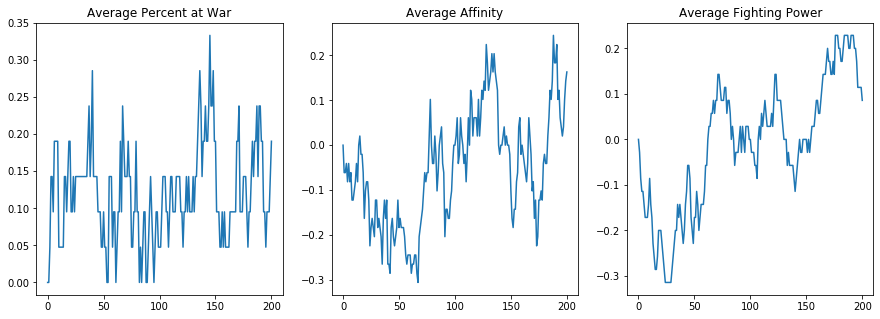

In [6]:
def plot_histories(wh, ah, ph):
    plt.figure(figsize=(15, 5))
    for i, hist in enumerate([('Percent at War', wh), ('Affinity', ah), ('Fighting Power', ph)]):
        plt.subplot(131 + i)
        plt.plot(range(len(hist[1])), hist[1])
        plt.title('Average {}'.format(hist[0]))
    plt.show()
    
def sums(hh):
    return [h.sum(axis=0) for h in hh]

def hist_by_country(nets, i):
    return [s[i] for s in nets]

def plot_extended(fh):
    plt.figure(figsize=(10, 15))
    for i, hist in enumerate([('Conflict Intensity', (sums(fh[0]))),
                              ('Net Allies', (sums(fh[1]))),
                              ('Power History', (fh[2]))]):
        plt.subplot(311 + i)
        for i in range(N):
            h = hist_by_country(hist[1], i)
            plt.plot(range(len(h)), h, label=countries_full()[i])
            plt.title('{}'.format(hist[0]))
        plt.legend()
    plt.show()
    
plot_histories(wh, ah, ph)

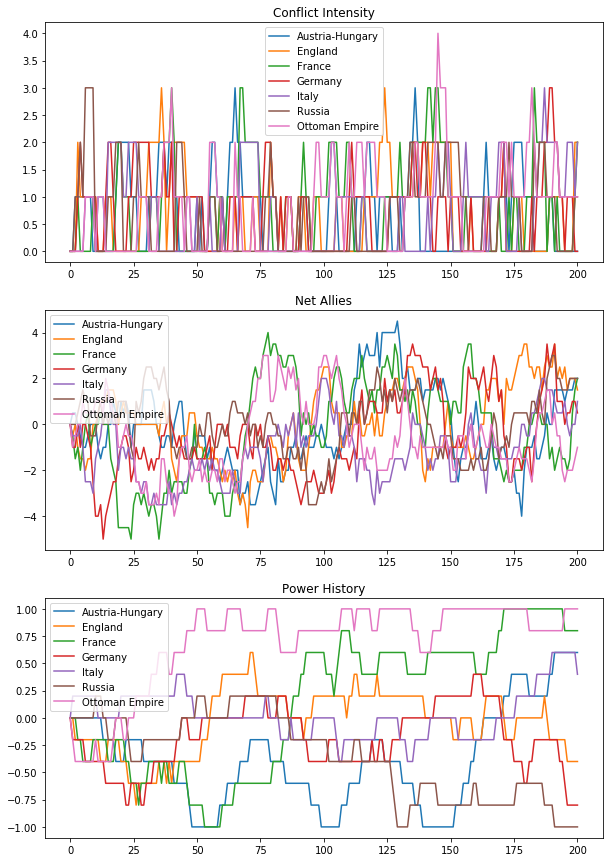

In [7]:
plot_extended(fh)

Some helper functions:

In [8]:
def allied(c1, c2, aff):
    return aff[c1][c2] > .99

def allied_war(c1, c2, war0, aff0):
    # C1's ally is at war with C2, or C2's ally is at war with C1
    return any([True for c3 in range(N) if war0[c2][c3] and allied(c1, c3, aff0)]) or \
           any([True for c3 in range(N) if war0[c1][c3] and allied(c2, c3, aff0)])

In [9]:
def war_init():
    return np.zeros((N, N))

def affinity_init():
    return np.array([
        #   A,   E,   F,   G,   I,   R,   T
        [   0,   0,   0,   1,   1,   0,   0],  # A
        [   0,   0,  .5,   0,   0,  .5,   0],  # E
        [   0,  .5,   0,   0,   0,   1,   0],  # F
        [   1,   0,   0,   0,   1,   0,   1],  # G
        [   1,   0,   0,   1,   0,   0,   0],  # I
        [   0,  .5,   1,   0,   0,   0,   0],  # R
        [   0,   0,   0,   1,   0,   0,   0]   # T
    ])

def power_init():
    #                  A,   E,   F,   G,   I,   R,   T
    return np.array([0.1,  .4,  .2,  .6, 0.1, 0.1, 0.1])

def base_power_trans():
    # build up power over time
    return np.array([(.05, -.2), (.05, -.1), (.15, 0), (.2, .1), (.25, .2), (.3, .3)])

Slightly more complicated update rules:

- A country enters war if its allies are at war or a triggering event happens and its power is at least 0.
- A country exits war if either power is depleted to -1.
- Affinities are manually initiated.
- Affinities are fixed.
- Power is manually initiated.
- Power tends to increase naturally if a country is not at war.
- Power changes if a country is at war. It rises with allies and falls with enemies.

In [10]:
def war(c1, c2, war0, aff0, pow0, agg, event):
    if pow0[c1] < -.99 or pow0[c2] < -.99:
        return 0.0
    elif pow0[c1] < 0 and war0[c1][c2] < 1:
        return 0.0
    elif allied_war(c1, c2, war0, aff0) and pow0[c1] >= -.01:
        return 1.0
    else:
        w = war0[c1][c2] + change(base_war_trans())
        return bound(disc(w, 'w'), 'w')

def affinity(c1, c2, war0, aff0, pow0):
    return aff0[c1][c2]

def power(c1, war0, aff0, pow0, prox):
    step_size = 0.2
    war_coeff = 1
    p = pow0[c1]
    if np.sum(war0[c1]) > 0:
        p -= step_size * np.sum(war0[c1] * [pow0 + 1])
        p += war_coeff * change(base_power_trans())
    else:
        p += change(base_power_trans())
    return bound(disc(p, 'p'), 'p')

In [11]:
wh, ah, ph, fh = run_sim(4 * 10, verbose=True)

------------------------------------------------------------------------------------------
ROUND 0
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.40 
 
 
 2 
 0.20 
 
 
 3 
 0.60 
 
 
 4 
 0.10 
 
 
 5 
 0.10 
 
 
 6 
 0.10

------------------------------------------------------------------------------------------
ROUND 1
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.40 
 
 
 2 
 0.30 
 
 
 3 
 0.90 
 
 
 4 
 0.20 
 
 
 5 
 0.20 
 
 
 6 
 0.10

------------------------------------------------------------------------------------------
ROUND 2
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.60 
 
 
 2 
 0.50 
 
 
 3 
 0.90 
 
 
 4 
 0.50 
 
 
 5 
 0.10 
 
 
 6 
 0.10

------------------------------------------------------------------------------------------
ROUND 3
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.00 
 
 
 1 
 0.60 
 
 
 2 
 0.50 
 
 
 3 
 0.90 
 
 
 4 
 0.70 
 
 
 5 
 0.40 
 
 
 6 
 -0.20

------------------------------------------------------------------------------------------
ROUND 4
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.40 
 
 
 2 
 0.50 
 
 
 3 
 0.60 
 
 
 4 
 1.00 
 
 
 5 
 0.70 
 
 
 6 
 -0.40

------------------------------------------------------------------------------------------
ROUND 5
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 -0.90 
 
 
 2 
 0.70 
 
 
 3 
 0.60 
 
 
 4 
 0.90 
 
 
 5 
 0.90 
 
 
 6 
 -0.40

------------------------------------------------------------------------------------------
ROUND 6
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 -1.00 
 
 
 2 
 0.20 
 
 
 3 
 0.80 
 
 
 4 
 1.00 
 
 
 5 
 0.80 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 7
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 -1.00 
 
 
 2 
 -0.40 
 
 
 3 
 0.90 
 
 
 4 
 1.00 
 
 
 5 
 0.80 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 8
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 -1.00 
 
 
 2 
 -0.90 
 
 
 3 
 1.00 
 
 
 4 
 1.00 
 
 
 5 
 0.90 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 9
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.60 
 
 
 1 
 -0.70 
 
 
 2 
 -1.00 
 
 
 3 
 0.50 
 
 
 4 
 0.40 
 
 
 5 
 0.80 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 10
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 -0.60 
 
 
 2 
 -1.00 
 
 
 3 
 -0.40 
 
 
 4 
 -0.30 
 
 
 5 
 0.10 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 11
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 -0.50 
 
 
 2 
 -0.80 
 
 
 3 
 -0.70 
 
 
 4 
 -0.50 
 
 
 5 
 -0.10 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 12
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 -0.20 
 
 
 2 
 -0.60 
 
 
 3 
 -0.80 
 
 
 4 
 -0.80 
 
 
 5 
 0.00 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 13
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 -0.10 
 
 
 2 
 -0.40 
 
 
 3 
 -0.80 
 
 
 4 
 -0.90 
 
 
 5 
 -0.30 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 14
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.20 
 
 
 2 
 -0.30 
 
 
 3 
 -0.90 
 
 
 4 
 -0.70 
 
 
 5 
 -0.40 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 15
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 0.00 
 
 
 2 
 -0.10 
 
 
 3 
 -0.70 
 
 
 4 
 -0.60 
 
 
 5 
 -0.30 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 16
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 0.20 
 
 
 2 
 0.20 
 
 
 3 
 -1.00 
 
 
 4 
 -0.40 
 
 
 5 
 -0.70 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 17
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.50 
 
 
 1 
 -0.00 
 
 
 2 
 0.10 
 
 
 3 
 -1.00 
 
 
 4 
 -0.60 
 
 
 5 
 -0.80 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 18
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 -0.10 
 
 
 2 
 0.20 
 
 
 3 
 -0.90 
 
 
 4 
 -0.80 
 
 
 5 
 -0.90 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 19
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.00 
 
 
 2 
 0.40 
 
 
 3 
 -0.60 
 
 
 4 
 -1.00 
 
 
 5 
 -0.80 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 20
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.90 
 
 
 1 
 -0.20 
 
 
 2 
 0.40 
 
 
 3 
 -0.60 
 
 
 4 
 -1.00 
 
 
 5 
 -0.70 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 21
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 -0.40 
 
 
 2 
 0.50 
 
 
 3 
 -0.70 
 
 
 4 
 -0.90 
 
 
 5 
 -0.40 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 22
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 -0.40 
 
 
 2 
 0.70 
 
 
 3 
 -0.80 
 
 
 4 
 -1.00 
 
 
 5 
 -0.40 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 23
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 -0.20 
 
 
 2 
 1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 -0.20 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 24
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 -0.10 
 
 
 2 
 1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -0.90 
 
 
 5 
 -0.10 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 25
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.80 
 
 
 4 
 -0.60 
 
 
 5 
 0.10 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 26
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.80 
 
 
 4 
 -0.40 
 
 
 5 
 0.40 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 27
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.60 
 
 
 4 
 -0.30 
 
 
 5 
 0.70 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 28
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.60 
 
 
 4 
 -0.40 
 
 
 5 
 0.70 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 29
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.90 
 
 
 4 
 -0.70 
 
 
 5 
 0.60 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 30
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.00 
 
 
 1 
 0.10 
 
 
 2 
 0.90 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 0.80 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 31
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 -0.30 
 
 
 2 
 1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 0.90 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 32
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 -0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.70 
 
 
 4 
 -1.00 
 
 
 5 
 1.00 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 33
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.10 
 
 
 2 
 1.00 
 
 
 3 
 -0.40 
 
 
 4 
 -0.80 
 
 
 5 
 1.00 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 34
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.00 
 
 
 2 
 1.00 
 
 
 3 
 -0.50 
 
 
 4 
 -0.50 
 
 
 5 
 1.00 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 35
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.00 
 
 
 2 
 0.80 
 
 
 3 
 -0.60 
 
 
 4 
 -0.70 
 
 
 5 
 1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 36
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.90 
 
 
 1 
 0.20 
 
 
 2 
 0.60 
 
 
 3 
 -0.70 
 
 
 4 
 -1.00 
 
 
 5 
 1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 37
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.90 
 
 
 1 
 0.50 
 
 
 2 
 0.60 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 1.00 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 38
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.60 
 
 
 2 
 0.90 
 
 
 3 
 -1.00 
 
 
 4 
 -0.70 
 
 
 5 
 0.80 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 39
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.60 
 
 
 2 
 1.00 
 
 
 3 
 -0.70 
 
 
 4 
 -0.60 
 
 
 5 
 1.00 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 40
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.90 
 
 
 1 
 0.90 
 
 
 2 
 1.00 
 
 
 3 
 -0.40 
 
 
 4 
 -0.40 
 
 
 5 
 1.00 
 
 
 6 
 -1.00

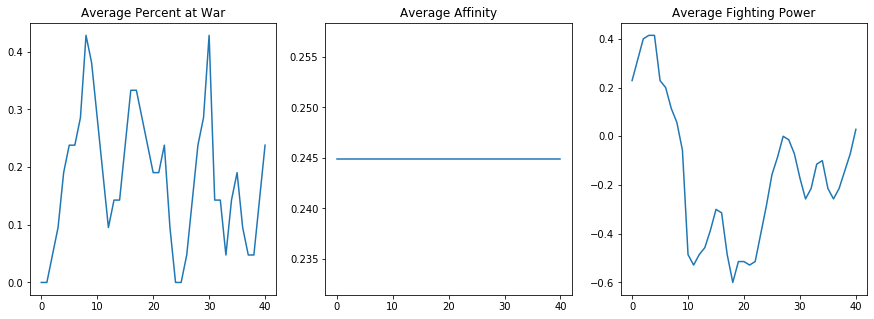

In [12]:
plot_histories(wh, ah, ph)

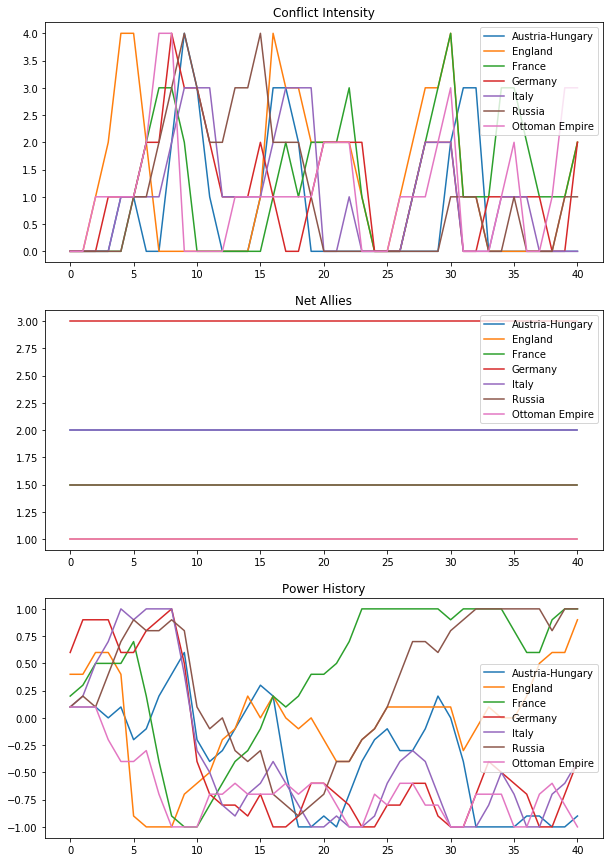

In [13]:
plot_extended(fh)

More rules:

- Events can now initiate a war; the event matrix represents the past-independent probability of such an event triggering.

In [14]:
def balkans_event():
    return np.array([
        #   A,   E,   F,   G,   I,   R,   T
        [   0,   0,   0,   0,   0, .25,   0],  # A
        [   0,   0,   0,   0,   0,   0,   0],  # E
        [   0,   0,   0,   0,   0,   0,   0],  # F
        [   0,   0,   0,   0,   0,   0,   0],  # G
        [   0,   0,   0,   0,   0,   0,   0],  # I
        [ .25,   0,   0,   0,   0,   0,  .1],  # R
        [   0,   0,   0,   0,   0,  .1,   0],  # T
    ])

In [15]:
from numpy.random import random

def war(c1, c2, war0, aff0, pow0, agg, event):
    if pow0[c1] < -.99 or pow0[c2] < -.99:
        return 0.0
    elif pow0[c1] < 0 and war0[c1][c2] < .01:
        return 0.0
    elif random() < event[c1][c2]:
        return 1.0
    elif allied_war(c1, c2, war0, aff0) and pow0[c1] >= -.01:
        return 1.0
    else:
        w = war0[c1][c2] + change(base_war_trans())
        return bound(disc(w, 'w'), 'w')

In [16]:
wh, ah, ph, fh = run_sim(4 * 10, balkans_event(), verbose=True)

------------------------------------------------------------------------------------------
ROUND 0
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.40 
 
 
 2 
 0.20 
 
 
 3 
 0.60 
 
 
 4 
 0.10 
 
 
 5 
 0.10 
 
 
 6 
 0.10

------------------------------------------------------------------------------------------
ROUND 1
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.30 
 
 
 2 
 0.50 
 
 
 3 
 0.90 
 
 
 4 
 0.20 
 
 
 5 
 -0.10 
 
 
 6 
 0.10

------------------------------------------------------------------------------------------
ROUND 2
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.00 
 
 
 1 
 0.40 
 
 
 2 
 0.80 
 
 
 3 
 0.90 
 
 
 4 
 0.30 
 
 
 5 
 -0.20 
 
 
 6 
 -0.20

------------------------------------------------------------------------------------------
ROUND 3
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 0.60 
 
 
 2 
 0.70 
 
 
 3 
 0.90 
 
 
 4 
 0.30 
 
 
 5 
 -1.00 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 4
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 0.90 
 
 
 2 
 -0.30 
 
 
 3 
 0.90 
 
 
 4 
 -0.00 
 
 
 5 
 -1.00 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 5
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.50 
 
 
 1 
 0.80 
 
 
 2 
 -0.80 
 
 
 3 
 0.90 
 
 
 4 
 0.10 
 
 
 5 
 -0.80 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 6
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 0.80 
 
 
 2 
 -1.00 
 
 
 3 
 1.00 
 
 
 4 
 0.20 
 
 
 5 
 -0.60 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 7
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.90 
 
 
 2 
 -1.00 
 
 
 3 
 1.00 
 
 
 4 
 0.20 
 
 
 5 
 -1.00 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 8
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 0.70 
 
 
 2 
 -1.00 
 
 
 3 
 1.00 
 
 
 4 
 0.10 
 
 
 5 
 -1.00 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 9
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.90 
 
 
 2 
 -0.90 
 
 
 3 
 0.60 
 
 
 4 
 -0.20 
 
 
 5 
 -0.80 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 10
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 1.00 
 
 
 2 
 -0.60 
 
 
 3 
 0.20 
 
 
 4 
 -0.30 
 
 
 5 
 -0.70 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 11
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 1.00 
 
 
 2 
 -0.30 
 
 
 3 
 -0.10 
 
 
 4 
 -0.20 
 
 
 5 
 -0.40 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 12
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.00 
 
 
 1 
 0.80 
 
 
 2 
 -0.50 
 
 
 3 
 0.00 
 
 
 4 
 -0.40 
 
 
 5 
 -0.30 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 13
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.00 
 
 
 1 
 1.00 
 
 
 2 
 -0.40 
 
 
 3 
 -0.00 
 
 
 4 
 -0.80 
 
 
 5 
 -0.40 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 14
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.80 
 
 
 2 
 -0.30 
 
 
 3 
 0.10 
 
 
 4 
 -0.90 
 
 
 5 
 -0.20 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 15
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 1.00 
 
 
 2 
 -0.00 
 
 
 3 
 0.10 
 
 
 4 
 -1.00 
 
 
 5 
 -0.20 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 16
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.80 
 
 
 1 
 1.00 
 
 
 2 
 0.20 
 
 
 3 
 0.00 
 
 
 4 
 -1.00 
 
 
 5 
 -0.40 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 17
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 1.00 
 
 
 2 
 0.50 
 
 
 3 
 -0.10 
 
 
 4 
 -0.90 
 
 
 5 
 -0.10 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 18
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 1.00 
 
 
 2 
 0.80 
 
 
 3 
 -0.10 
 
 
 4 
 -0.80 
 
 
 5 
 -0.20 
 
 
 6 
 -0.50

------------------------------------------------------------------------------------------
ROUND 19
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 1.00 
 
 
 2 
 0.90 
 
 
 3 
 -0.30 
 
 
 4 
 -0.80 
 
 
 5 
 -0.20 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 20
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.50 
 
 
 1 
 1.00 
 
 
 2 
 0.70 
 
 
 3 
 -0.50 
 
 
 4 
 -1.00 
 
 
 5 
 0.00 
 
 
 6 
 -0.90

------------------------------------------------------------------------------------------
ROUND 21
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.50 
 
 
 1 
 1.00 
 
 
 2 
 0.80 
 
 
 3 
 -0.80 
 
 
 4 
 -1.00 
 
 
 5 
 0.10 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 22
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 1.00 
 
 
 2 
 1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -0.70 
 
 
 5 
 0.30 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 23
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 1.00 
 
 
 2 
 1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -0.50 
 
 
 5 
 0.50 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 24
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 2 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 0.30 
 
 
 2 
 0.80 
 
 
 3 
 -0.70 
 
 
 4 
 -1.00 
 
 
 5 
 0.70 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 25
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 -0.40 
 
 
 2 
 0.50 
 
 
 3 
 -0.40 
 
 
 4 
 -1.00 
 
 
 5 
 0.50 
 
 
 6 
 -0.40

------------------------------------------------------------------------------------------
ROUND 26
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 -0.90 
 
 
 2 
 0.40 
 
 
 3 
 -0.70 
 
 
 4 
 -1.00 
 
 
 5 
 0.50 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 27
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 -1.00 
 
 
 2 
 0.50 
 
 
 3 
 -0.70 
 
 
 4 
 -0.70 
 
 
 5 
 0.80 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 28
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.80 
 
 
 1 
 -1.00 
 
 
 2 
 0.60 
 
 
 3 
 -0.90 
 
 
 4 
 -0.50 
 
 
 5 
 0.60 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 29
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 -0.70 
 
 
 2 
 0.70 
 
 
 3 
 -1.00 
 
 
 4 
 -0.60 
 
 
 5 
 0.60 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 30
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 -0.40 
 
 
 2 
 0.70 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 0.70 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 31
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 -0.10 
 
 
 2 
 0.70 
 
 
 3 
 -0.70 
 
 
 4 
 -1.00 
 
 
 5 
 0.70 
 
 
 6 
 -0.90

------------------------------------------------------------------------------------------
ROUND 32
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 0.20 
 
 
 2 
 0.80 
 
 
 3 
 -0.40 
 
 
 4 
 -0.80 
 
 
 5 
 0.90 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 33
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.40 
 
 
 2 
 0.80 
 
 
 3 
 -0.20 
 
 
 4 
 -0.80 
 
 
 5 
 1.00 
 
 
 6 
 -0.50

------------------------------------------------------------------------------------------
ROUND 34
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.00 
 
 
 1 
 0.60 
 
 
 2 
 0.90 
 
 
 3 
 0.10 
 
 
 4 
 -0.50 
 
 
 5 
 1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 35
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 0.70 
 
 
 2 
 1.00 
 
 
 3 
 0.10 
 
 
 4 
 -0.50 
 
 
 5 
 1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 36
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.50 
 
 
 1 
 0.90 
 
 
 2 
 1.00 
 
 
 3 
 -0.70 
 
 
 4 
 -0.70 
 
 
 5 
 0.90 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 37
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.50 
 
 
 1 
 1.00 
 
 
 2 
 0.70 
 
 
 3 
 -1.00 
 
 
 4 
 -0.90 
 
 
 5 
 0.80 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 38
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 1.00 
 
 
 2 
 0.20 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 0.40 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 39
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 1.00 
 
 
 2 
 0.20 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 0.50 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 40
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.90 
 
 
 1 
 1.00 
 
 
 2 
 -0.10 
 
 
 3 
 -0.80 
 
 
 4 
 -1.00 
 
 
 5 
 0.60 
 
 
 6 
 -0.80

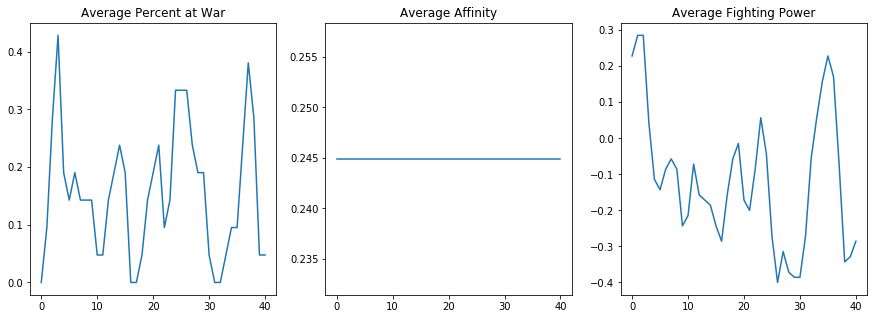

In [17]:
plot_histories(wh, ah, ph)

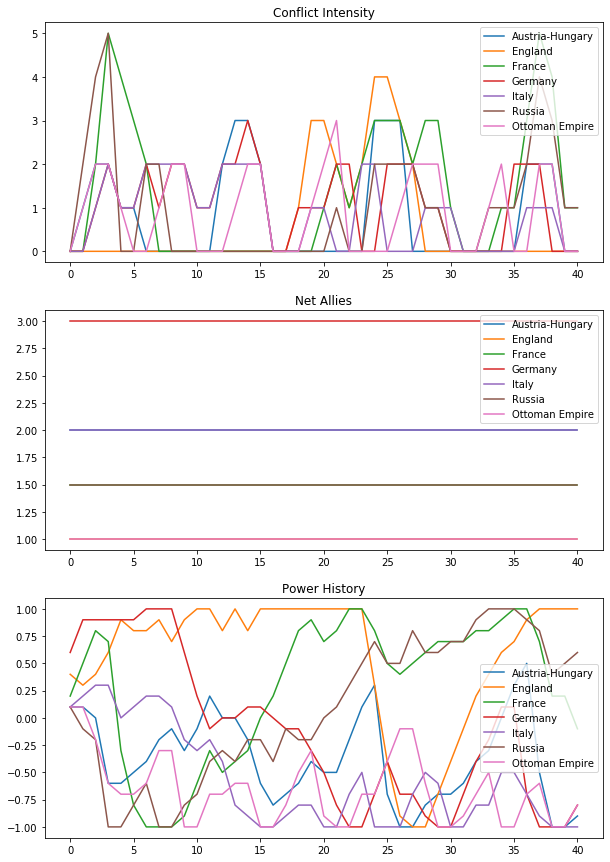

In [18]:
plot_extended(fh)

More rules:

- Power is now affected by proximity.
- Affinities can shift again, but by less.

In [19]:
def war(c1, c2, war0, aff0, pow0, agg, event):
    if pow0[c1] < -.99 or pow0[c2] < -.99:
        return 0.0
    elif pow0[c1] < 0 and war0[c1][c2] < .01:
        return 0.0
    elif random() < event[c1][c2]:
        return 1.0
    elif allied_war(c1, c2, war0, aff0) and pow0[c1] >= -.01:
        return 1.0
    else:
        w = war0[c1][c2] - 0.1 * aff0[c1][c2] + change(base_war_trans())
        return bound(disc(w, 'w'), 'w')

def base_affinity_trans():
    #                   down 2,      down 1,      same,       up 1,      up 2
    return np.array([(.02, -1),   (.05, -.5),  (.83, 0),  (.06, .5),  (.04, 1)])

def affinity(c1, c2, war0, aff0, pow0):
    if war0[c1][c2]:
        return -1.0
    aff1 = aff0[c1][c2] + change(base_affinity_trans())
    return bound(disc(aff1, 'a'), 'a')

def power(c1, war0, aff0, pow0, prox):
    step_size = 0.2
    war_coeff = 1
    p = pow0[c1]
    if np.sum(war0[c1]) > 0:
        p -= step_size * np.sum(war0[c1] * [pow0 + 1] * prox[c1])
        p += war_coeff * change(base_power_trans())
    else:
        p += change(base_power_trans())
    return bound(disc(p, 'p'), 'p')

In [20]:
wh, ah, ph, fh = run_sim(4 * 10, balkans_event(), verbose=True)

------------------------------------------------------------------------------------------
ROUND 0
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.00 
 0.00 
 0.50 
 0.00 
 
 
 2 
 0.00 
 0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.40 
 
 
 2 
 0.20 
 
 
 3 
 0.60 
 
 
 4 
 0.10 
 
 
 5 
 0.10 
 
 
 6 
 0.10

------------------------------------------------------------------------------------------
ROUND 1
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 1.00 
 0.00 
 -0.50 
 0.00 
 
 
 2 
 0.00 
 -0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 -0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 0.60 
 
 
 2 
 0.50 
 
 
 3 
 0.70 
 
 
 4 
 0.30 
 
 
 5 
 0.30 
 
 
 6 
 0.30

------------------------------------------------------------------------------------------
ROUND 2
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 1.00 
 -0.50 
 -0.50 
 0.50 
 
 
 2 
 0.00 
 -0.50 
 0.00 
 0.00 
 1.00 
 -1.00 
 0.00 
 
 
 3 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.50 
 1.00 
 
 
 4 
 1.00 
 -0.50 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 -0.50 
 -1.00 
 0.50 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.50 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.60 
 
 
 1 
 0.90 
 
 
 2 
 0.50 
 
 
 3 
 1.00 
 
 
 4 
 0.50 
 
 
 5 
 0.40 
 
 
 6 
 0.50

------------------------------------------------------------------------------------------
ROUND 3
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 -1.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 1.00 
 -0.50 
 -0.50 
 0.50 
 
 
 2 
 0.00 
 -0.50 
 0.00 
 0.00 
 1.00 
 -1.00 
 0.00 
 
 
 3 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.50 
 1.00 
 
 
 4 
 1.00 
 -0.50 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 -1.00 
 -0.50 
 -1.00 
 0.50 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.50 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.60 
 
 
 1 
 1.00 
 
 
 2 
 0.50 
 
 
 3 
 1.00 
 
 
 4 
 0.70 
 
 
 5 
 0.00 
 
 
 6 
 0.70

------------------------------------------------------------------------------------------
ROUND 4
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 1.00 
 1.00 
 -1.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 1.00 
 0.50 
 0.00 
 1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 1.00 
 -1.00 
 0.00 
 
 
 3 
 1.00 
 1.00 
 -0.50 
 0.00 
 1.00 
 -1.00 
 1.00 
 
 
 4 
 1.00 
 0.50 
 1.00 
 1.00 
 0.00 
 -1.00 
 1.00 
 
 
 5 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 1.00 
 
 
 2 
 0.50 
 
 
 3 
 0.60 
 
 
 4 
 0.90 
 
 
 5 
 -1.00 
 
 
 6 
 0.50

------------------------------------------------------------------------------------------
ROUND 5
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.50 
 -1.00 
 1.00 
 1.00 
 -1.00 
 1.00 
 
 
 1 
 0.50 
 0.00 
 -0.50 
 1.00 
 1.00 
 -1.00 
 1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 1.00 
 -1.00 
 0.00 
 
 
 3 
 1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 1.00 
 
 
 4 
 1.00 
 1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 1.00 
 
 
 2 
 0.80 
 
 
 3 
 0.40 
 
 
 4 
 0.90 
 
 
 5 
 -1.00 
 
 
 6 
 0.60

------------------------------------------------------------------------------------------
ROUND 6
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 
 
 1 
 0.50 
 0.00 
 -0.50 
 1.00 
 -1.00 
 -1.00 
 1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 
 
 3 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 1.00 
 1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.80 
 
 
 2 
 0.50 
 
 
 3 
 -0.70 
 
 
 4 
 0.30 
 
 
 5 
 -1.00 
 
 
 6 
 0.50

------------------------------------------------------------------------------------------
ROUND 7
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.80 
 
 
 1 
 0.40 
 
 
 2 
 0.10 
 
 
 3 
 -1.00 
 
 
 4 
 0.00 
 
 
 5 
 -1.00 
 
 
 6 
 0.20

------------------------------------------------------------------------------------------
ROUND 8
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.10 
 
 
 2 
 -0.10 
 
 
 3 
 -1.00 
 
 
 4 
 -0.40 
 
 
 5 
 -1.00 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 9
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 5 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 0.00 
 -0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 -0.10 
 
 
 2 
 -0.40 
 
 
 3 
 -0.70 
 
 
 4 
 -0.40 
 
 
 5 
 -0.70 
 
 
 6 
 -0.20

------------------------------------------------------------------------------------------
ROUND 10
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 0.00 
 -0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.80 
 
 
 1 
 0.00 
 
 
 2 
 -0.60 
 
 
 3 
 -0.40 
 
 
 4 
 -0.40 
 
 
 5 
 -0.40 
 
 
 6 
 0.00

------------------------------------------------------------------------------------------
ROUND 11
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 0.00 
 1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 0.20 
 
 
 2 
 -0.70 
 
 
 3 
 -0.10 
 
 
 4 
 -0.20 
 
 
 5 
 -0.10 
 
 
 6 
 -0.20

------------------------------------------------------------------------------------------
ROUND 12
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 
 
 6 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 -0.00 
 
 
 2 
 -0.90 
 
 
 3 
 -0.20 
 
 
 4 
 -0.10 
 
 
 5 
 0.00 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 13
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 1.00 
 -1.00 
 0.00 
 0.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 -0.20 
 
 
 2 
 -0.80 
 
 
 3 
 -0.10 
 
 
 4 
 -0.10 
 
 
 5 
 -0.20 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 14
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.50 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 -0.40 
 
 
 2 
 -0.80 
 
 
 3 
 0.00 
 
 
 4 
 0.00 
 
 
 5 
 -0.10 
 
 
 6 
 0.20

------------------------------------------------------------------------------------------
ROUND 15
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.50 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 0.00 
 0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 -0.90 
 
 
 2 
 -0.60 
 
 
 3 
 -0.00 
 
 
 4 
 0.00 
 
 
 5 
 -0.20 
 
 
 6 
 0.40

------------------------------------------------------------------------------------------
ROUND 16
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.50 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 0.00 
 0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 -1.00 
 
 
 2 
 -0.40 
 
 
 3 
 0.20 
 
 
 4 
 0.10 
 
 
 5 
 -0.50 
 
 
 6 
 0.40

------------------------------------------------------------------------------------------
ROUND 17
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 0.50 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 0.50 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 -1.00 
 
 
 2 
 -0.20 
 
 
 3 
 0.20 
 
 
 4 
 -0.10 
 
 
 5 
 -0.80 
 
 
 6 
 0.40

------------------------------------------------------------------------------------------
ROUND 18
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 -0.90 
 
 
 2 
 -0.40 
 
 
 3 
 0.30 
 
 
 4 
 -0.30 
 
 
 5 
 -1.00 
 
 
 6 
 0.30

------------------------------------------------------------------------------------------
ROUND 19
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 -0.50 
 0.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 -1.00 
 -0.50 
 -0.50 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 -0.90 
 
 
 2 
 -0.30 
 
 
 3 
 0.60 
 
 
 4 
 -0.40 
 
 
 5 
 -1.00 
 
 
 6 
 0.50

------------------------------------------------------------------------------------------
ROUND 20
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 -0.50 
 0.00 
 0.00 
 0.00 
 -1.00 
 0.50 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 0.00 
 1.00 
 
 
 6 
 -0.50 
 -1.00 
 -0.50 
 -0.50 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 -1.00 
 
 
 2 
 -0.30 
 
 
 3 
 0.50 
 
 
 4 
 -0.60 
 
 
 5 
 -0.70 
 
 
 6 
 0.80

------------------------------------------------------------------------------------------
ROUND 21
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 -0.50 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.50 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 -1.00 
 -0.50 
 -0.50 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 -0.00 
 
 
 1 
 -0.70 
 
 
 2 
 -0.60 
 
 
 3 
 0.70 
 
 
 4 
 -0.70 
 
 
 5 
 -0.60 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 22
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 0.50 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 -1.00 
 -0.50 
 -0.50 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 0.00 
 
 
 1 
 -0.80 
 
 
 2 
 -0.40 
 
 
 3 
 0.70 
 
 
 4 
 -0.70 
 
 
 5 
 -0.60 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 23
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 -0.50 
 
 
 2 
 -0.20 
 
 
 3 
 0.50 
 
 
 4 
 -0.70 
 
 
 5 
 -0.40 
 
 
 6 
 0.70

------------------------------------------------------------------------------------------
ROUND 24
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 -0.70 
 
 
 2 
 0.00 
 
 
 3 
 0.10 
 
 
 4 
 -0.70 
 
 
 5 
 -0.50 
 
 
 6 
 0.60

------------------------------------------------------------------------------------------
ROUND 25
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 1.00 
 -1.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 0.50 
 
 
 6 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 -0.00 
 
 
 1 
 -0.50 
 
 
 2 
 -0.20 
 
 
 3 
 0.00 
 
 
 4 
 -0.80 
 
 
 5 
 -0.40 
 
 
 6 
 0.80

------------------------------------------------------------------------------------------
ROUND 26
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 1.00 
 0.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 -0.30 
 
 
 2 
 0.00 
 
 
 3 
 -0.20 
 
 
 4 
 -0.60 
 
 
 5 
 -0.50 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 27
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.50 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 1.00 
 0.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 -0.10 
 
 
 2 
 0.20 
 
 
 3 
 -0.30 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 28
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.50 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 1.00 
 0.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.00 
 -0.50 
 0.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.10 
 
 
 2 
 0.20 
 
 
 3 
 -0.10 
 
 
 4 
 -0.10 
 
 
 5 
 -0.30 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 29
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 1.00 
 0.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.00 
 -0.50 
 0.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 0.40 
 
 
 2 
 0.50 
 
 
 3 
 -0.10 
 
 
 4 
 0.20 
 
 
 5 
 -0.00 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 30
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -0.50 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.50 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 0.70 
 
 
 2 
 0.70 
 
 
 3 
 0.20 
 
 
 4 
 0.20 
 
 
 5 
 0.20 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 31
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 0.00 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 -0.50 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.00 
 
 
 1 
 1.00 
 
 
 2 
 0.50 
 
 
 3 
 0.30 
 
 
 4 
 -0.10 
 
 
 5 
 0.20 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 32
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 -0.50 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 -0.50 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.10 
 
 
 1 
 1.00 
 
 
 2 
 0.60 
 
 
 3 
 0.40 
 
 
 4 
 -0.10 
 
 
 5 
 -0.10 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 33
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 -0.50 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 1.00 
 
 
 2 
 0.90 
 
 
 3 
 0.60 
 
 
 4 
 0.00 
 
 
 5 
 -0.20 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 34
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.50 
 -1.00 
 -0.50 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.50 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 1.00 
 
 
 2 
 0.70 
 
 
 3 
 0.60 
 
 
 4 
 0.20 
 
 
 5 
 -0.60 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 35
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 0.50 
 -1.00 
 -0.50 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.50 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.10 
 
 
 1 
 1.00 
 
 
 2 
 0.70 
 
 
 3 
 0.90 
 
 
 4 
 0.00 
 
 
 5 
 -0.70 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 36
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 1.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 0.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 0.50 
 -1.00 
 -0.50 
 -0.50 
 
 
 3 
 0.50 
 -1.00 
 0.50 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 1.00 
 
 
 2 
 0.70 
 
 
 3 
 1.00 
 
 
 4 
 -0.20 
 
 
 5 
 -1.00 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 37
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 0.50 
 -1.00 
 -1.00 
 0.50 
 
 
 1 
 1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 0.50 
 0.00 
 -0.50 
 0.50 
 
 
 3 
 0.50 
 -1.00 
 0.50 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.50 
 0.50 
 0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.50 
 
 
 1 
 0.80 
 
 
 2 
 0.60 
 
 
 3 
 1.00 
 
 
 4 
 -0.60 
 
 
 5 
 -1.00 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 38
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 0.50 
 
 
 1 
 1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 0.50 
 
 
 3 
 1.00 
 -1.00 
 1.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 0.50 
 0.50 
 0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.80 
 
 
 1 
 0.90 
 
 
 2 
 0.90 
 
 
 3 
 1.00 
 
 
 4 
 -0.50 
 
 
 5 
 -0.70 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 39
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 1.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 0.50 
 
 
 3 
 1.00 
 -1.00 
 1.00 
 0.00 
 -0.50 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.50 
 0.50 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 1.00 
 
 
 1 
 0.90 
 
 
 2 
 1.00 
 
 
 3 
 0.90 
 
 
 4 
 -0.50 
 
 
 5 
 -0.40 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 40
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 1.00 
 
 
 1 
 1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 1.00 
 
 
 3 
 1.00 
 -1.00 
 1.00 
 0.00 
 -0.50 
 0.50 
 -1.00 
 
 
 4 
 -1.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -0.50 
 0.50 
 -0.50 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.50 
 1.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 
 0 
 
 0 
 1.00 
 
 
 1 
 1.00 
 
 
 2 
 1.00 
 
 
 3 
 1.00 
 
 
 4 
 -0.30 
 
 
 5 
 -0.30 
 
 
 6 
 1.00

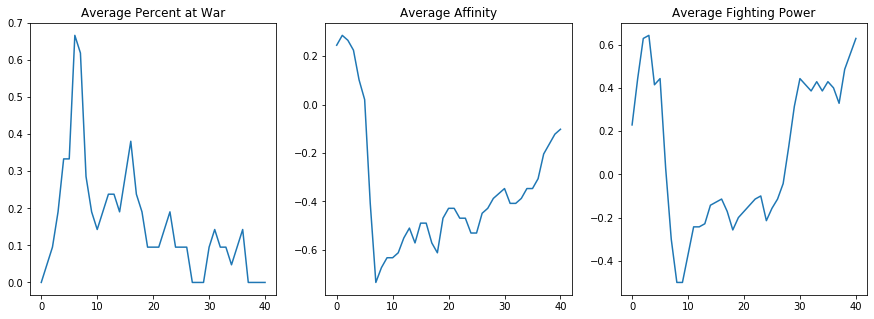

In [21]:
plot_histories(wh, ah, ph)

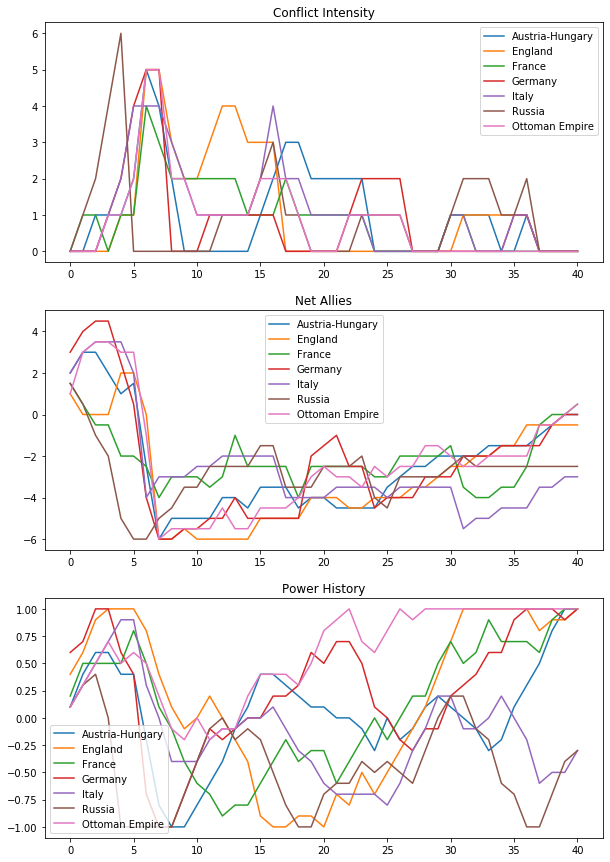

In [22]:
plot_extended(fh)

Now let's run with some real values! Affinity and power derived from CoW (see other notebook).

In [23]:
def affinity_init():
    return np.array([
        #   A,   E,   F,   G,   I,   R,   T
        [   0.,  0.,  0.,  1.,  1.,  0.,  0.],
        [   0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [   0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [   1.,  0.,  0.,  0.,  1.,  0.,  0.],
        [   1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [   0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [   0.,  0.,  0.,  0.,  0.,  0.,  0.]
    ])

def power_init():
    #                   A,    E,    F,    G,    I,    R,    T
    return np.array([0.31, 0.44, 0.93, 0.18, 0.74, 0.07, 0.78])

def base_war_trans():
    return np.array([(.01, -1), (.98, 0), (.01, 1)])

def base_power_trans():
    # build up power over time
    return np.array([(.1, -.1), (.6, 0), (.15, .1), (.15, .2)])

In [24]:
wh, ah, ph, fh = run_sim(4 * 10, no_event(), verbose=True)

------------------------------------------------------------------------------------------
ROUND 0
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 
 
 0 
 0.31 
 
 
 1 
 0.44 
 
 
 2 
 0.93 
 
 
 3 
 0.18 
 
 
 4 
 0.74 
 
 
 5 
 0.07 
 
 
 6 
 0.78

------------------------------------------------------------------------------------------
ROUND 1
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -0.50 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 -0.50 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 -0.50 
 
 
 5 
 0.00 
 -0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.50 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.50 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 0.60 
 
 
 2 
 0.80 
 
 
 3 
 0.20 
 
 
 4 
 0.70 
 
 
 5 
 0.10 
 
 
 6 
 0.80

------------------------------------------------------------------------------------------
ROUND 2
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 -0.50 
 
 
 5 
 0.00 
 -0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.50 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.50 
 0.00 
 
 0 
 
 0 
 0.30 
 
 
 1 
 0.60 
 
 
 2 
 1.00 
 
 
 3 
 0.30 
 
 
 4 
 0.80 
 
 
 5 
 0.20 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 3
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 0.00 
 0.00 
 -0.50 
 0.00 
 
 
 2 
 0.00 
 -0.50 
 0.00 
 0.00 
 0.00 
 1.00 
 0.50 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 -0.50 
 
 
 5 
 0.00 
 -0.50 
 1.00 
 0.00 
 0.00 
 0.00 
 0.50 
 
 
 6 
 0.00 
 0.00 
 0.50 
 0.00 
 -0.50 
 0.50 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 0.80 
 
 
 2 
 1.00 
 
 
 3 
 0.30 
 
 
 4 
 0.90 
 
 
 5 
 0.10 
 
 
 6 
 1.00

------------------------------------------------------------------------------------------
ROUND 4
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.50 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.50 
 
 
 3 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 -0.50 
 
 
 5 
 0.00 
 -0.50 
 1.00 
 0.00 
 1.00 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.50 
 0.50 
 0.00 
 -0.50 
 0.50 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 0.80 
 
 
 2 
 1.00 
 
 
 3 
 0.30 
 
 
 4 
 0.90 
 
 
 5 
 0.10 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 5
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.50 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.50 
 0.00 
 1.00 
 0.50 
 
 
 3 
 1.00 
 0.00 
 0.50 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 4 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 -0.50 
 
 
 5 
 0.00 
 -0.50 
 1.00 
 0.00 
 1.00 
 0.00 
 0.50 
 
 
 6 
 -0.50 
 0.50 
 0.50 
 0.00 
 -0.50 
 0.50 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 0.80 
 
 
 2 
 1.00 
 
 
 3 
 0.30 
 
 
 4 
 1.00 
 
 
 5 
 0.20 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 6
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 -0.50 
 -1.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.50 
 0.00 
 1.00 
 0.50 
 
 
 3 
 1.00 
 0.00 
 0.50 
 0.00 
 0.50 
 0.00 
 -0.50 
 
 
 4 
 1.00 
 -0.50 
 0.00 
 0.50 
 0.00 
 1.00 
 -0.50 
 
 
 5 
 0.00 
 -1.00 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 -0.50 
 1.00 
 0.50 
 -0.50 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.40 
 
 
 1 
 0.80 
 
 
 2 
 1.00 
 
 
 3 
 0.40 
 
 
 4 
 1.00 
 
 
 5 
 0.20 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 7
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 -0.50 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 -1.00 
 -1.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.50 
 0.00 
 1.00 
 0.50 
 
 
 3 
 1.00 
 0.00 
 0.50 
 0.00 
 0.50 
 0.00 
 -0.50 
 
 
 4 
 1.00 
 -1.00 
 0.00 
 0.50 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.00 
 -1.00 
 1.00 
 0.00 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -0.50 
 1.00 
 0.50 
 -0.50 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.50 
 
 
 1 
 0.80 
 
 
 2 
 1.00 
 
 
 3 
 0.60 
 
 
 4 
 1.00 
 
 
 5 
 0.20 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 8
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.50 
 0.00 
 0.50 
 1.00 
 
 
 3 
 1.00 
 0.00 
 0.50 
 0.00 
 0.50 
 0.00 
 0.50 
 
 
 4 
 1.00 
 -1.00 
 0.00 
 0.50 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.00 
 0.00 
 0.50 
 0.00 
 0.50 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 0.50 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.50 
 
 
 1 
 0.80 
 
 
 2 
 1.00 
 
 
 3 
 0.60 
 
 
 4 
 1.00 
 
 
 5 
 0.20 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 9
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.50 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 -0.50 
 -1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.50 
 0.00 
 0.50 
 1.00 
 
 
 3 
 1.00 
 -0.50 
 0.50 
 0.00 
 0.50 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 0.00 
 0.50 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 0.00 
 0.50 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.70 
 
 
 1 
 1.00 
 
 
 2 
 1.00 
 
 
 3 
 0.60 
 
 
 4 
 1.00 
 
 
 5 
 0.20 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 10
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.50 
 1.00 
 1.00 
 0.50 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 -1.00 
 -1.00 
 0.00 
 1.00 
 
 
 2 
 0.50 
 0.50 
 0.00 
 0.50 
 0.00 
 0.50 
 1.00 
 
 
 3 
 1.00 
 -1.00 
 0.50 
 0.00 
 0.00 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 0.00 
 0.00 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 0.00 
 0.50 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.70 
 
 
 1 
 0.90 
 
 
 2 
 1.00 
 
 
 3 
 0.60 
 
 
 4 
 1.00 
 
 
 5 
 0.20 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 11
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.50 
 1.00 
 1.00 
 0.50 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 -0.50 
 -1.00 
 0.00 
 1.00 
 
 
 2 
 0.50 
 0.50 
 0.00 
 0.50 
 0.50 
 0.50 
 1.00 
 
 
 3 
 1.00 
 -0.50 
 0.50 
 0.00 
 0.00 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 0.50 
 0.00 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 0.00 
 0.50 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.90 
 
 
 1 
 0.90 
 
 
 2 
 1.00 
 
 
 3 
 0.80 
 
 
 4 
 1.00 
 
 
 5 
 0.30 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 12
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.50 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.50 
 -1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 0.50 
 0.00 
 0.50 
 0.50 
 0.50 
 1.00 
 
 
 3 
 1.00 
 0.50 
 0.50 
 0.00 
 1.00 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 0.50 
 1.00 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 0.00 
 0.50 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.80 
 
 
 1 
 0.90 
 
 
 2 
 1.00 
 
 
 3 
 0.80 
 
 
 4 
 0.90 
 
 
 5 
 0.30 
 
 
 6 
 0.90

------------------------------------------------------------------------------------------
ROUND 13
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.50 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 0.50 
 -1.00 
 1.00 
 1.00 
 
 
 2 
 1.00 
 0.50 
 0.00 
 0.50 
 0.50 
 0.50 
 1.00 
 
 
 3 
 1.00 
 0.50 
 0.50 
 0.00 
 1.00 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 0.50 
 1.00 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 1.00 
 0.50 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.80 
 
 
 1 
 0.90 
 
 
 2 
 0.90 
 
 
 3 
 0.80 
 
 
 4 
 0.90 
 
 
 5 
 0.30 
 
 
 6 
 0.80

------------------------------------------------------------------------------------------
ROUND 14
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 1.00 
 1.00 
 0.50 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 0.50 
 1.00 
 -1.00 
 1.00 
 1.00 
 
 
 2 
 -1.00 
 0.50 
 0.00 
 0.50 
 0.50 
 0.00 
 1.00 
 
 
 3 
 1.00 
 1.00 
 0.50 
 0.00 
 1.00 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 0.50 
 1.00 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 1.00 
 0.00 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.70 
 
 
 1 
 1.00 
 
 
 2 
 0.90 
 
 
 3 
 0.80 
 
 
 4 
 0.90 
 
 
 5 
 0.20 
 
 
 6 
 0.80

------------------------------------------------------------------------------------------
ROUND 15
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 3 
 1.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 4 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 5 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 1.00 
 1.00 
 0.50 
 -1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 1.00 
 -1.00 
 1.00 
 1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 
 
 3 
 1.00 
 1.00 
 -1.00 
 0.00 
 1.00 
 -0.50 
 1.00 
 
 
 4 
 1.00 
 -1.00 
 -1.00 
 1.00 
 0.00 
 0.50 
 -0.50 
 
 
 5 
 0.50 
 1.00 
 -1.00 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 1.00 
 1.00 
 1.00 
 -0.50 
 1.00 
 0.00 
 
 0 
 
 0 
 0.20 
 
 
 1 
 1.00 
 
 
 2 
 0.20 
 
 
 3 
 0.40 
 
 
 4 
 0.60 
 
 
 5 
 0.30 
 
 
 6 
 0.50

------------------------------------------------------------------------------------------
ROUND 16
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 
 
 1 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 
 
 3 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 4 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 
 6 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 1.00 
 1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 1.00 
 -1.00 
 0.00 
 0.00 
 -0.50 
 -1.00 
 
 
 4 
 1.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 0.50 
 -1.00 
 
 
 5 
 -1.00 
 1.00 
 -1.00 
 -0.50 
 0.50 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.50 
 
 
 2 
 -1.00 
 
 
 3 
 -0.30 
 
 
 4 
 0.20 
 
 
 5 
 0.30 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 17
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 1.00 
 1.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 1.00 
 0.00 
 
 0 
 
 0 
 -1.00 
 
 
 1 
 0.40 
 
 
 2 
 -1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -0.20 
 
 
 5 
 0.00 
 
 
 6 
 -0.20

------------------------------------------------------------------------------------------
ROUND 18
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.80 
 
 
 1 
 0.20 
 
 
 2 
 -1.00 
 
 
 3 
 -1.00 
 
 
 4 
 -0.50 
 
 
 5 
 -0.20 
 
 
 6 
 -0.40

------------------------------------------------------------------------------------------
ROUND 19
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.80 
 
 
 1 
 0.20 
 
 
 2 
 -0.80 
 
 
 3 
 -1.00 
 
 
 4 
 -0.80 
 
 
 5 
 -0.50 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 20
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.10 
 
 
 2 
 -0.90 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 -0.70 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 21
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.10 
 
 
 2 
 -0.90 
 
 
 3 
 -1.00 
 
 
 4 
 -1.00 
 
 
 5 
 -0.70 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 22
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.30 
 
 
 2 
 -0.90 
 
 
 3 
 -1.00 
 
 
 4 
 -0.80 
 
 
 5 
 -0.80 
 
 
 6 
 -0.90

------------------------------------------------------------------------------------------
ROUND 23
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.30 
 
 
 2 
 -0.90 
 
 
 3 
 -0.90 
 
 
 4 
 -0.80 
 
 
 5 
 -1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 24
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.50 
 
 
 2 
 -0.80 
 
 
 3 
 -0.90 
 
 
 4 
 -0.80 
 
 
 5 
 -1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 25
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 -1.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.60 
 
 
 2 
 -0.60 
 
 
 3 
 -0.90 
 
 
 4 
 -0.60 
 
 
 5 
 -1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 26
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 -0.50 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 1.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 6 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.80 
 
 
 2 
 -0.50 
 
 
 3 
 -0.90 
 
 
 4 
 -0.40 
 
 
 5 
 -1.00 
 
 
 6 
 -1.00

------------------------------------------------------------------------------------------
ROUND 27
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 -0.50 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 2 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 1.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -0.50 
 -1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 6 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.70 
 
 
 1 
 0.70 
 
 
 2 
 -0.50 
 
 
 3 
 -0.70 
 
 
 4 
 -0.40 
 
 
 5 
 -1.00 
 
 
 6 
 -0.90

------------------------------------------------------------------------------------------
ROUND 28
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 1.00 
 -1.00 
 -0.50 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 0.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 1.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 6 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.60 
 
 
 1 
 0.60 
 
 
 2 
 -0.60 
 
 
 3 
 -0.60 
 
 
 4 
 -0.40 
 
 
 5 
 -0.80 
 
 
 6 
 -0.80

------------------------------------------------------------------------------------------
ROUND 29
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 6 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 0.60 
 
 
 2 
 -0.90 
 
 
 3 
 -0.70 
 
 
 4 
 -0.40 
 
 
 5 
 -0.80 
 
 
 6 
 -0.70

------------------------------------------------------------------------------------------
ROUND 30
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 0.00 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -0.50 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 
 
 6 
 0.00 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.40 
 
 
 1 
 0.50 
 
 
 2 
 -1.00 
 
 
 3 
 -0.70 
 
 
 4 
 -0.40 
 
 
 5 
 -0.60 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 31
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -1.00 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 0.50 
 
 
 1 
 -1.00 
 0.00 
 -1.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 2 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -0.50 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 -0.50 
 -0.50 
 0.00 
 0.00 
 -1.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 6 
 0.50 
 -1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.70 
 
 
 2 
 -1.00 
 
 
 3 
 -0.80 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 32
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -0.50 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 0.50 
 
 
 1 
 -0.50 
 0.00 
 0.00 
 1.00 
 -0.50 
 0.00 
 -0.50 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 
 4 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 6 
 0.50 
 -0.50 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.80 
 
 
 2 
 -1.00 
 
 
 3 
 -0.90 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 -0.60

------------------------------------------------------------------------------------------
ROUND 33
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 -0.50 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 1.00 
 
 
 1 
 -0.50 
 0.00 
 0.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 6 
 1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.80 
 
 
 2 
 -1.00 
 
 
 3 
 -0.70 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 -0.40

------------------------------------------------------------------------------------------
ROUND 34
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 -1.00 
 0.50 
 -1.00 
 -0.50 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 2 
 -1.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 
 
 6 
 1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.90 
 
 
 2 
 -1.00 
 
 
 3 
 -0.60 
 
 
 4 
 -0.20 
 
 
 5 
 -0.60 
 
 
 6 
 -0.40

------------------------------------------------------------------------------------------
ROUND 35
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.50 
 0.00 
 -0.50 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -0.50 
 1.00 
 -0.50 
 0.50 
 -1.00 
 
 
 2 
 0.00 
 -0.50 
 0.00 
 -0.50 
 0.00 
 -0.50 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -0.50 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 0.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 -0.50 
 0.00 
 
 
 5 
 -0.50 
 0.50 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 
 
 6 
 1.00 
 -1.00 
 -1.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.90 
 
 
 2 
 -1.00 
 
 
 3 
 -0.60 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 36
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.50 
 0.00 
 -0.50 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 1.00 
 -0.50 
 0.50 
 0.00 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.00 
 -0.50 
 -1.00 
 
 
 3 
 0.50 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 0.00 
 -0.50 
 0.00 
 -1.00 
 0.00 
 -0.50 
 0.00 
 
 
 5 
 -0.50 
 0.50 
 -0.50 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 
 
 6 
 1.00 
 0.00 
 -1.00 
 -0.50 
 0.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.80 
 
 
 2 
 -1.00 
 
 
 3 
 -0.60 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 37
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 -0.50 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 1.00 
 -0.50 
 0.50 
 -0.50 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 -0.50 
 -1.00 
 
 
 3 
 1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -1.00 
 
 
 4 
 0.00 
 -0.50 
 0.50 
 -1.00 
 0.00 
 -1.00 
 0.00 
 
 
 5 
 -0.50 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 
 
 6 
 1.00 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 1.00 
 
 
 2 
 -0.90 
 
 
 3 
 -0.60 
 
 
 4 
 -0.30 
 
 
 5 
 -0.60 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 38
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.50 
 1.00 
 
 
 1 
 0.00 
 0.00 
 -1.00 
 1.00 
 -1.00 
 0.50 
 -0.50 
 
 
 2 
 0.00 
 -1.00 
 0.00 
 -1.00 
 0.50 
 -0.50 
 0.00 
 
 
 3 
 1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 -0.50 
 
 
 4 
 0.00 
 -1.00 
 0.50 
 -1.00 
 0.00 
 -1.00 
 0.00 
 
 
 5 
 0.50 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 
 
 6 
 1.00 
 -0.50 
 0.00 
 -0.50 
 0.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.20 
 
 
 1 
 0.90 
 
 
 2 
 -0.70 
 
 
 3 
 -0.50 
 
 
 4 
 -0.50 
 
 
 5 
 -0.40 
 
 
 6 
 -0.30

------------------------------------------------------------------------------------------
ROUND 39
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 -1.00 
 0.50 
 -0.50 
 
 
 2 
 0.00 
 0.00 
 0.00 
 -1.00 
 0.50 
 -0.50 
 0.00 
 
 
 3 
 1.00 
 1.00 
 -1.00 
 0.00 
 -1.00 
 -1.00 
 0.00 
 
 
 4 
 0.00 
 -1.00 
 0.50 
 -1.00 
 0.00 
 -1.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 -0.50 
 
 
 6 
 1.00 
 -0.50 
 0.00 
 0.00 
 0.00 
 -0.50 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.80 
 
 
 2 
 -0.50 
 
 
 3 
 -0.50 
 
 
 4 
 -0.50 
 
 
 5 
 -0.50 
 
 
 6 
 -0.10

------------------------------------------------------------------------------------------
ROUND 40
------------------------------------------------------------------------------------------


0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 0.00 
 1.00 
 0.00 
 1.00 
 
 
 2 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 6 
 0.00 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 0 1 2 3 4 5 6 
 
 0 
 0.00 
 0.00 
 0.00 
 1.00 
 -0.50 
 0.00 
 1.00 
 
 
 1 
 0.00 
 0.00 
 0.00 
 1.00 
 -1.00 
 0.50 
 -0.50 
 
 
 2 
 0.00 
 0.00 
 0.00 
 -1.00 
 0.50 
 -0.50 
 1.00 
 
 
 3 
 1.00 
 1.00 
 -1.00 
 0.00 
 0.00 
 -1.00 
 0.00 
 
 
 4 
 -0.50 
 -1.00 
 0.50 
 0.00 
 0.00 
 -1.00 
 0.00 
 
 
 5 
 0.00 
 0.50 
 -0.50 
 -1.00 
 -1.00 
 0.00 
 0.50 
 
 
 6 
 1.00 
 -0.50 
 1.00 
 0.00 
 0.00 
 0.50 
 0.00 
 
 0 
 
 0 
 -0.30 
 
 
 1 
 0.80 
 
 
 2 
 -0.50 
 
 
 3 
 -0.50 
 
 
 4 
 -0.70 
 
 
 5 
 -0.50 
 
 
 6 
 -0.10

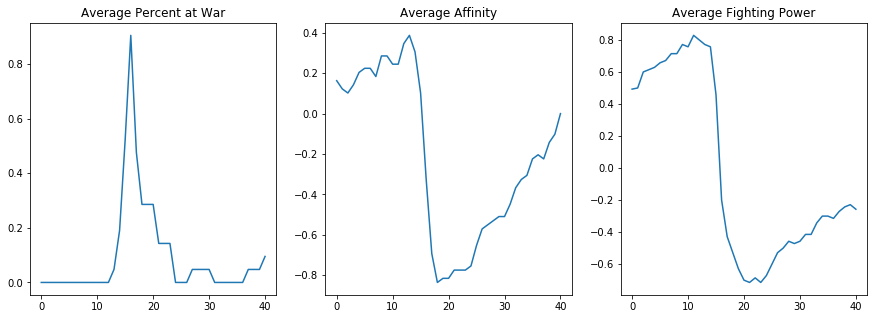

In [25]:
plot_histories(wh, ah, ph)

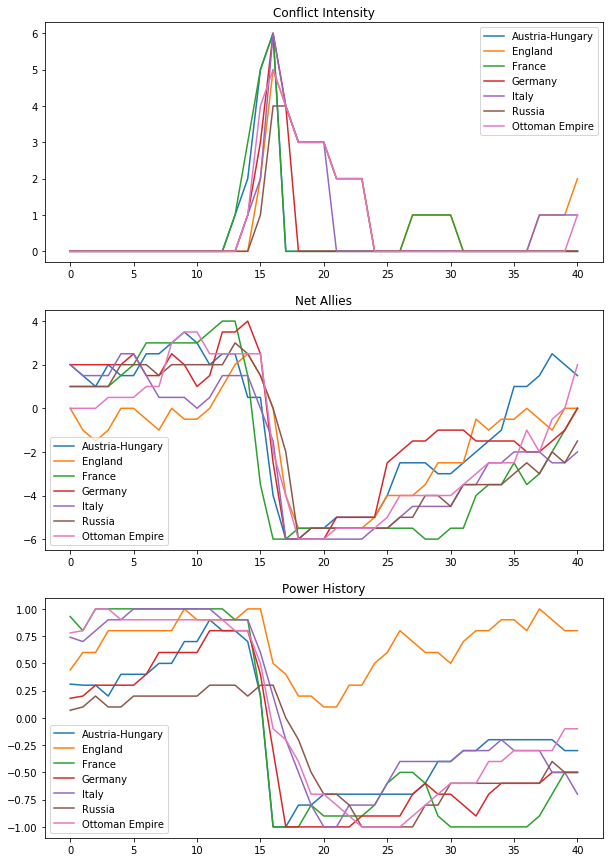

In [26]:
plot_extended(fh)

Questions to answer:

1. How does war vary with event trigger frequency?
2. How does war depend on alliances?

Let's see about the first:

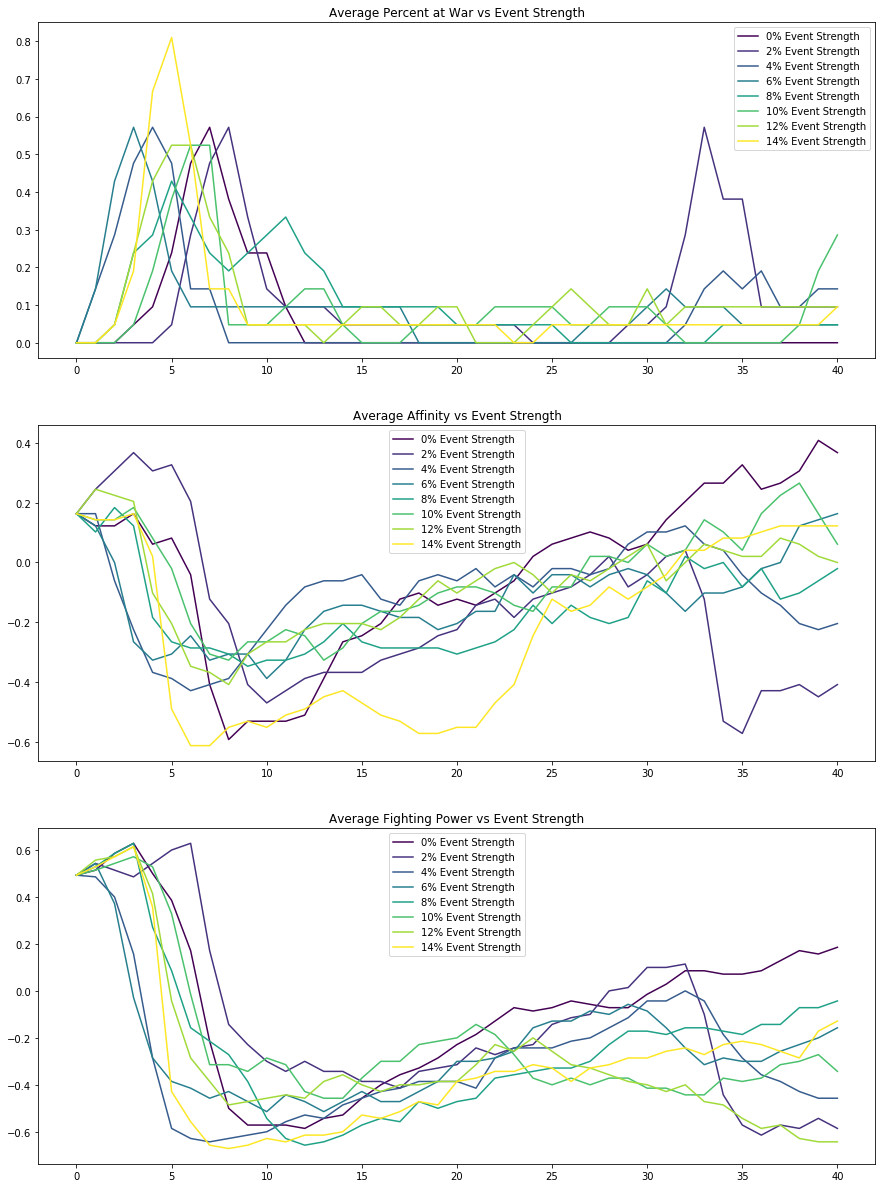

In [27]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def event_with_strength(s):
    return np.random.random((N, N)) * s

event_histories = []
for s in np.arange(0, .16, .02):
    wh, ah, ph, fh = run_sim(4 * 10, event_with_strength(s), verbose=False)
    event_histories.append(('%d%%'%int(s*100), wh, ah, ph))

def plot_multihist(eh, legend_var, cm):
    plt.figure(figsize=(15, 21))
    for i, title in enumerate(['Percent at War', 'Affinity', 'Fighting Power']):
        plt.subplot(311 + i)
        for j, tup in enumerate(eh):
            plt.plot(range(len(tup[i+1])), tup[i+1],
                     label='%s %s' % (tup[0], legend_var),
                     color = cm(j/len(eh)))
        plt.title('Average {} vs {}'.format(title, legend_var))
        plt.legend()
    plt.show()
    
plot_multihist(event_histories, 'Event Strength', cm.get_cmap('viridis', len(event_histories)))

Now the second:

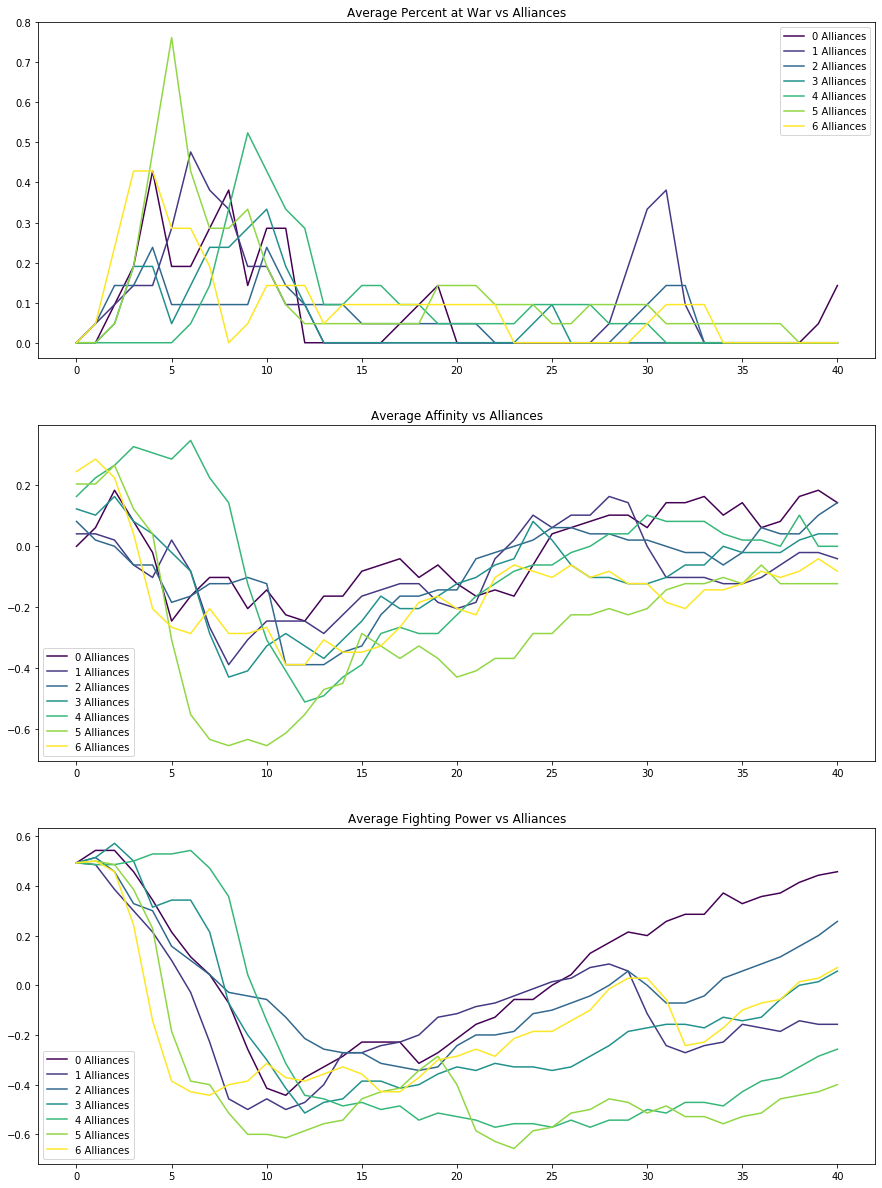

In [28]:
def has_alliance(i, j, ai):
    # 0 1 2 3 4 5 6
    # A B F G I R T
    # Historical order: A-G, A-I, G-I, F-R, B-F, B-R, G-T
    alliances = {
        '0-3': 1,
        '0-4': 2,
        '3-4': 3,
        '2-5': 4,
        '1-2': 5,
        '1-5': 6,
        '3-6': 7,
    }
    key = '{}-{}'.format(min(i,j), max(i,j))
    return key in alliances and ai >= alliances[key]

event_histories = []
for ai in np.arange(0, 7, 1):
    affinity_init = lambda: np.array([[has_alliance(i, j, ai) * 1.0 for i in range(N)] for j in range(N)])
    wh, ah, ph, fh = run_sim(4 * 10, balkans_event(), verbose=False)
    event_histories.append(('%d'%ai, wh, ah, ph))

plot_multihist(event_histories, 'Alliances', cm.get_cmap('viridis', len(event_histories)))

In conclusion:

1. Events make war faster and sharper.
2. Alliances suck if external events can drag you into war against everybody's better judgment.
3. Kate rocks.